# [BirdCLEF2023](https://www.kaggle.com/competitions/birdclef-2023)


[Inference notebook](https://www.kaggle.com/code/ollypowell/birdclef-2023-pytorch-lightning-inference) 

Original Forks: [Generate spectrograms](https://www.kaggle.com/code/nischaydnk/split-creating-melspecs-stage-1), [Training](https://www.kaggle.com/code/nischaydnk/birdclef-2023-pytorch-lightning-training-w-cmap), [Inference](https://www.kaggle.com/code/nischaydnk/birdclef-2023-pytorch-lightning-inference)


Version 79, same as 78, but with more selective dataset 29k extras 4-12  // 1.5

## Imports

In [22]:
import os
in_kaggle = os.environ.get('PWD') == '/kaggle/working'
if in_kaggle:
    %pip install -q torchtoolbox timm colorednoise
else:
    #working = "/home/olly/Desktop/BirdCLEF23/Kaggle_Kernel/"
    working = "C:/Users/ollyp\Desktop\BirdClef23/Kaggle_Kernel"
    os.chdir(working) # Set to folder containing the data files
print("Current working directory: {0}".format(os.getcwd()))
print(working)

Current working directory: C:\Users\ollyp\Desktop\BirdClef23\Kaggle_Kernel
C:/Users/ollyp\Desktop\BirdClef23/Kaggle_Kernel


In [23]:
import timm 
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc
import warnings
import random 
from pathlib import Path
import plotly.express as px
import plotly.io as pio
import seaborn as sns
pio.renderers.default = 'notebook'


# Torch and PyTorch
import torch
import torch.nn.functional as F
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint,  EarlyStopping
import torch.nn as nn
from torch.utils.data import  DataLoader
from torch.utils.data.sampler import Sampler
from torch.optim.lr_scheduler import  CosineAnnealingWarmRestarts
import timm

#ML Modules
from sklearn.model_selection import StratifiedKFold
import sklearn.metrics as skm
import albumentations as A

#Audio 
import torchaudio
import librosa
import colorednoise as cn

## Configuration

In [24]:
class Config:
    #Training Parameters
    #DEBUG = 200 #shrinks the size of the datasets by that factor, otherwise None
    DEBUG = None
    EXPERIMENT = 83
    NUM_WORKERS = 0
    NUM_CLASSES = 264
    BATCH_SIZE = 32  # was 64 on kaggle, reduced in case of memory errors
    EPOCHS = 24
    PRECISION = 16    
    PATIENCE = 2
    KEEP_LAST= 14
    MIN_DELTA = 0
    SEED = 2023
    MODEL = 'tf_efficientnetv2_s' # "tf_efficientnetv2_s_in21k"  #Outperformed tf_efficientnetv2_s & tf_efficientnet_b0_ns
    PRETRAINED = True   #Load Efficientnet Weights
    BIRD_TRAINED = False #Additional training on Birdclef21-23
    REPLACE_HEAD = True # Use the BIRD_TRAINED backbone but replace the classifier head
    WEIGHTED_SAMPLING = False 
    WEIGHT_DECAY = 1e-5
    LR = 1e-4
    EPOCHS_TO_UNFREEZE_HEAD = 0  # Only matters if a two-part head
    EPOCHS_TO_UNFREEZE_BACKBONE = 3
    WARMUP_EPOCHS = None
    START_LR = 1e-4  #Not needed if WARMUP_EPOCHS = None
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    LOSS_FUNCTION =  nn.CrossEntropyLoss() #  #nn.BCEWithLogitsLoss() #
    IMAGE_SIZE = 256
    RARE_THRESHOLD = 4
    USE_MIXUP= True
    AUG = 1  # Factor by which to reduce augmentation
    MIXUP_ALPHA = .5
    USE_EXTRAS = True
    AUTOLRFIND = True
    LABEL_SMOOTHING = 0.1
    
    #Train and CV Parameters
    N_FOLDS = 10  # But I'll probably only use one fold initially
    RARE_THRESHOLD = 4 # Samples with less than this many values will not be allowed in valuation

    if in_kaggle:
        MODEL_CKPT = '/kaggle/input/Expt26_Weights/last.ckpt'
        OUT_DIR = '/kaggle/working'
        LABELS_PATH = "/kaggle/input/birdclef23-train-8-sec-wav/train_23_cropped.csv"
        BACKGROUND_NOISE_FLDR = '/kaggle/input/birdclef23-uniform-noise-chunks/birdclef23-backgrounds'
        NOCALLS = '/kaggle/input/birdclef-8-sec-ogg/birdclef-nocall.csv' # must be None or 'some_path'
    else:
        MODEL_CKPT = 'kaggle/input/Expt26_Weights/last.ckpt'  
        OUT_DIR = 'kaggle/working'
        #LABELS_PATH = "kaggle/input/birdclef21-train-8-sec-ogg/train_21_cropped.csv"
        LABELS_PATH = "kaggle/input/birdclef23-train-8-sec-wav/train_23_cropped.csv"
        EXTRA_LABELS_PATH = "kaggle/input/birdclef23-extras-8-sec-ogg/exp79-birdclef23-extra-labels-multiclass.csv"
        BACKGROUND_NOISE_FLDR = 'kaggle/input/birdclef23-uniform-noise-chunks/birdclef23-backgrounds'
        NOCALLS = 'kaggle/input/birdclef-8-sec-ogg/birdclef-nocall.csv' # must be None or 'some_path'  

In [25]:
class Audio:
    SR = 32000
    DURATION = 5  # Duration the loaded wav file will be cropped to.
    CHUNK_LENGTH = 8 # Maximum duration of the wav files
    N_MELS = 128 # Try increasing this to 256 later, once other experiments tried
    FMIN = 20
    FMAX = 14000
    WINDOW = 1024  
    HOP_LENGTH = 312
    N_FFT = 1024
    PCEN = False
    
    # last years 3rd place: two strategies
    # sr: 32000, window_size: 2048, hop_size: 1024, fmin: 200, fmax: 14000, mel_bins: 224
    # sr: 32000, window_size: 1024, hop_size: 512, fmin: 50, fmax: 14000, mel_bins: 128

## Setup

Create the train and validation splits using stratified-k-fold to keep the values representative of their class proportions. Later on when the differences are getting smaller and I'm choosing between options, base the CV scheme on 5 folds mean + one standard deviation.  This is too computationaly expensive for now.

In [26]:
pl.seed_everything(Config.SEED, workers=True)
torch.set_flush_denormal(True)
torch.set_float32_matmul_precision('medium')  # try next time
pd.set_option('display.max_colwidth', None)
warnings.filterwarnings('ignore')
save_path = Path(Config.OUT_DIR) / f'Exp{Config.EXPERIMENT}'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
accelerator = 'gpu' if torch.cuda.is_available() else 'cpu'
Config.PRECISION = 16 if accelerator == 'gpu' else 32
noise = Path(Config.BACKGROUND_NOISE_FLDR)
os.makedirs(save_path, exist_ok=True)
if in_kaggle:
    Audio.BACKGROUNDS = [noise / p for p in noise.rglob('*.wav')] #not sure this would actually work, need to check rglob only returns the file name
else:
    Audio.BACKGROUNDS = [p for p in noise.rglob('*.wav')]
f'There are {len(Audio.BACKGROUNDS)} Audio background files (each made up of concatenated 5 second random clips)'

Global seed set to 2023


'There are 74 Audio background files (each made up of concatenated 5 second random clips)'

In [27]:
use_cols = ['filepath', 'primary_label']
in_df = pd.read_csv(Config.LABELS_PATH,  usecols=use_cols)
print(f'There are {len(in_df)} samples from the first and last 8 seconds of each sound file')

if Config.USE_EXTRAS:
    extra_df = pd.read_csv(Config.EXTRA_LABELS_PATH,  usecols=use_cols)
    in_df = pd.concat([in_df, extra_df]).reset_index(drop=True)

if Config.NOCALLS:
    nocall_df = pd.read_csv(Config.NOCALLS, usecols=use_cols)
    in_df = pd.concat([in_df, nocall_df])
if Config.DEBUG is not None:
    in_df = in_df.sample(int(in_df.shape[0]/Config.DEBUG))
Config.NUM_CLASSES = len(in_df.primary_label.unique())
print(f'Training + Validation with {in_df.shape[0]} audio samples')
print(f'There are {Config.NUM_CLASSES} primary class labels')
in_df.head(3)

There are 30832 samples from the first and last 8 seconds of each sound file
Training + Validation with 61040 audio samples
There are 265 primary class labels


primary_label  \
0       abethr1   
1       abethr1   
2       abethr1   

                                                                      filepath  
0  /kaggle/input/birdclef23-train-8-sec-wav/train_audio/abethr1/XC128013_1.wav  
1  /kaggle/input/birdclef23-train-8-sec-wav/train_audio/abethr1/XC128013_2.wav  
2  /kaggle/input/birdclef23-train-8-sec-wav/train_audio/abethr1/XC363501_1.wav

Temporarily drop any super rare classes from the dataframe, so they don't end up loosing precious samples from training to the validation split.

In [28]:
mask = in_df['primary_label'].map(in_df['primary_label'].value_counts()) > Config.RARE_THRESHOLD
common_df = in_df[mask][['primary_label', 'filepath']]
mask = in_df['primary_label'].map(in_df['primary_label'].value_counts()) <= Config.RARE_THRESHOLD
rare_df = in_df[mask][['primary_label', 'filepath']]
rare_df.primary_label.value_counts()

lotlap1    3
golher1    2
whhsaw1    2
afpkin1    1
whctur2    1
Name: primary_label, dtype: int64

In [29]:
print(f'Temporarily removing {rare_df.shape[0]} rare instances from the dataset before splitting because'
      f' they have less than or equal to {Config.RARE_THRESHOLD} audio samples per class')

Temporarily removing 9 rare instances from the dataset before splitting because they have less than or equal to 4 audio samples per class


In [30]:
splits = 4 if Config.DEBUG else Config.N_FOLDS
skf =StratifiedKFold(n_splits=splits, shuffle=True, random_state=Config.SEED)
target = common_df['primary_label'] 

for train_index, val_index in skf.split(common_df, target):
    train_df, val_df = common_df.iloc[train_index], common_df.iloc[val_index]
train_df = pd.concat([train_df, rare_df])
    
print(f'The training dataframe has {train_df.shape[0]} rows\n'
      f'The validation dataframe has {val_df.shape[0]} rows')

The training dataframe has 54937 rows
The validation dataframe has 6103 rows


In [31]:
# Specifically check the filename column
train_df.head()

primary_label  \
0       abethr1   
1       abethr1   
2       abethr1   
3       abethr1   
5       abethr1   

                                                                      filepath  
0  /kaggle/input/birdclef23-train-8-sec-wav/train_audio/abethr1/XC128013_1.wav  
1  /kaggle/input/birdclef23-train-8-sec-wav/train_audio/abethr1/XC128013_2.wav  
2  /kaggle/input/birdclef23-train-8-sec-wav/train_audio/abethr1/XC363501_1.wav  
3  /kaggle/input/birdclef23-train-8-sec-wav/train_audio/abethr1/XC363501_2.wav  
5  /kaggle/input/birdclef23-train-8-sec-wav/train_audio/abethr1/XC363502_2.wav

Create & Fill birds with 0 samples in validation.  This is only needed because of the get-dummies approach with the dataframes.  The validation df misses out on columns for the missing species.  I also considered up-sampling the rare species, and ensuring one of the extra samples from each would go into the validation dataframe, but this would likely result in over-estimating the validation performance, and potentially over-fitting.

In [32]:
train_df = pd.concat([train_df, pd.get_dummies(train_df['primary_label'])], axis=1)
val_df = pd.concat([val_df, pd.get_dummies(val_df['primary_label'])], axis=1)
train_df.head(3)

primary_label  \
0       abethr1   
1       abethr1   
2       abethr1   

                                                                      filepath  \
0  /kaggle/input/birdclef23-train-8-sec-wav/train_audio/abethr1/XC128013_1.wav   
1  /kaggle/input/birdclef23-train-8-sec-wav/train_audio/abethr1/XC128013_2.wav   
2  /kaggle/input/birdclef23-train-8-sec-wav/train_audio/abethr1/XC363501_1.wav   

   abethr1  abhori1  abythr1  afbfly1  afdfly1  afecuc1  affeag1  afgfly1  \
0        1        0        0        0        0        0        0        0   
1        1        0        0        0        0        0        0        0   
2        1        0        0        0        0        0        0        0   

   ...  yebsto1  yeccan1  yefcan  yelbis1  yenspu1  yertin1  yesbar1  yespet1  \
0  ...        0        0       0        0        0        0        0        0   
1  ...        0        0       0        0        0        0        0        0   
2  ...        0        0       0        0        0        0        0        0   

   yetgre1  yewgre1  
0        0        0  
1        0        0  
2        0        0  

[3 rows x 267 columns]

In [33]:
birds = list(train_df.primary_label.unique())
missing_birds = list(set(list(train_df.primary_label.unique())).difference(list(val_df.primary_label.unique())))
non_missing_birds = list(set(list(train_df.primary_label.unique())).difference(missing_birds))
val_df[missing_birds] = 0
val_df = val_df[train_df.columns] ## Fix order
len(non_missing_birds)
val_df.head(3)

primary_label  \
4        abethr1   
16       abethr1   
18       abethr1   

                                                                       filepath  \
4   /kaggle/input/birdclef23-train-8-sec-wav/train_audio/abethr1/XC363502_1.wav   
16  /kaggle/input/birdclef23-train-8-sec-wav/train_audio/abethr1/XC467122_2.wav   
18  /kaggle/input/birdclef23-train-8-sec-wav/train_audio/abethr1/XC531557_2.wav   

    abethr1  abhori1  abythr1  afbfly1  afdfly1  afecuc1  affeag1  afgfly1  \
4         1        0        0        0        0        0        0        0   
16        1        0        0        0        0        0        0        0   
18        1        0        0        0        0        0        0        0   

    ...  yebsto1  yeccan1  yefcan  yelbis1  yenspu1  yertin1  yesbar1  \
4   ...        0        0       0        0        0        0        0   
16  ...        0        0       0        0        0        0        0   
18  ...        0        0       0        0        0        0        0   

    yespet1  yetgre1  yewgre1  
4         0        0        0  
16        0        0        0  
18        0        0        0  

[3 rows x 267 columns]

Helper functions and classes

In [34]:
def load_sf(wav_path, sr=Audio.SR):
    y, _ = librosa.load(wav_path, sr=sr)
    return y
    

def compute_pcen(y):
    if not np.isfinite(y).all():
        y[np.isnan(y)] = np.zeros_like(y)
        y[np.isinf(y)] = np.max(y)
    melspec = librosa.feature.melspectrogram(y=y, sr=Audio.SR, n_mels=Audio.N_MELS, n_fft= Audio.N_FFT, fmin=Audio.FMIN, fmax=Audio.FMAX)
    pcen = librosa.pcen(melspec, sr=Audio.SR, gain=0.98, bias=2, power=0.5, time_constant=0.4, eps=0.000001).astype(np.float32)
    return pcen


def compute_melspec(y):
    if not np.isfinite(y).all():
        y[np.isnan(y)] = np.zeros_like(y)
        y[np.isinf(y)] = np.max(y)
    melspec = librosa.feature.melspectrogram(y=y, sr=Audio.SR, n_mels=Audio.N_MELS, n_fft=Audio.N_FFT, hop_length = Audio.HOP_LENGTH, fmin=Audio.FMIN, fmax=Audio.FMAX)
    melspec = librosa.power_to_db(melspec)  #.astype(np.float32)
    return melspec


def mono_to_color(X, eps=1e-6, mean=None, std=None):
    _min, _max = X.min(), X.max()
    if (_max - _min) > eps:
        X = (X - _min) / (_max - _min) #scales to a range of [0,1]
        X = X.astype(np.float32)
    else:
        X = np.zeros_like(X, dtype=np.float32)
    X = np.stack([X, X, X], axis=-1) #puts the chanels last, like a normal image, for the ablu_trasformations
    return X


def crop_or_pad(y, length, train='train'):
    y = np.concatenate([y, y, y])
    if len(y) <= length:
        y = np.concatenate([y, np.zeros(length - len(y))])
    else:
        if train != 'train':
            start = 0
        else:
            start = np.random.randint(len(y) - length)
        y = y[start: start + length]
    return y

def random_crop(arr, length):
    start = np.random.randint(len(arr) - length)
    arr = arr[start: start + length]
    return arr


def reshape_image(arr):  #chop the image in half along the long dimension and stack to make more square
    cols = arr.shape[1]//2 
    remainder = arr.shape[1] % 2
    half1 = arr[:, :cols + remainder]
    half2 = arr[:, cols:]
    
    if np.random.choice([True,False], size=1)[0]:
        arr =  np.vstack((half1, half2))
    else:
        arr = np.vstack((half2, half1))
    return arr

In [35]:
class Compose:
    def __init__(self, transforms: list):
        self.transforms = transforms

    def __call__(self, y: np.ndarray, sr):
        for trns in self.transforms:
            y = trns(y, sr)
        return y


class AudioTransform:
    def __init__(self, always_apply=False, p=0.5):
        self.always_apply = always_apply
        self.p = p

    def __call__(self, y: np.ndarray, sr):
        if self.always_apply:
            return self.apply(y, sr=sr)
        else:
            if np.random.rand() < self.p:
                return self.apply(y, sr=sr)
            else:
                return y

    def apply(self, y: np.ndarray, **params):
        raise NotImplementedError


class OneOf(Compose):
    def __init__(self, transforms, p=0.5):
        super().__init__(transforms)
        self.p = p
        transforms_ps = [t.p for t in transforms]
        s = sum(transforms_ps)
        self.transforms_ps = [t / s for t in transforms_ps]

    def __call__(self, y: np.ndarray, sr):
        data = y
        if self.transforms_ps and (np.random.random() < self.p):
            random_state = np.random.RandomState(np.random.randint(0, 2 ** 16 - 1))
            t = random_state.choice(self.transforms, p=self.transforms_ps)
            data = t(y, sr)
        return data


class Normalize(AudioTransform):
    def __init__(self, always_apply=False, p=1):
        super().__init__(always_apply, p)

    def apply(self, y: np.ndarray, **params):
        max_vol = np.abs(y).max()
        y_vol = y * 1 / max_vol
        return np.asfortranarray(y_vol)


class NoiseInjection(AudioTransform):
    def __init__(self, always_apply=False, p=0.5, max_noise_level=0.5):
        super().__init__(always_apply, p)

        self.noise_level = (0.0, max_noise_level)

    def apply(self, y: np.ndarray, **params):
        noise_level = np.random.uniform(*self.noise_level)
        noise = np.random.randn(len(y))
        augmented = (y + noise * noise_level).astype(y.dtype)
        return augmented


class GaussianNoise(AudioTransform):
    def __init__(self, always_apply=False, p=0.5, min_snr=5, max_snr=20):
        super().__init__(always_apply, p)

        self.min_snr = min_snr
        self.max_snr = max_snr

    def apply(self, y: np.ndarray, **params):
        snr = np.random.uniform(self.min_snr, self.max_snr)
        a_signal = np.sqrt(y ** 2).max()
        a_noise = a_signal / (10 ** (snr / 20))

        white_noise = np.random.randn(len(y))
        a_white = np.sqrt(white_noise ** 2).max()
        augmented = (y + white_noise * 1 / a_white * a_noise).astype(y.dtype)
        return augmented

#https://github.com/felixpatzelt/colorednoise
class PinkNoise(AudioTransform):
    def __init__(self, always_apply=False, p=0.5, min_snr=5, max_snr=20):
        super().__init__(always_apply, p)

        self.min_snr = min_snr
        self.max_snr = max_snr

    def apply(self, y: np.ndarray, **params):
        snr = np.random.uniform(self.min_snr, self.max_snr)
        a_signal = np.sqrt(y ** 2).max()
        a_noise = a_signal / (10 ** (snr / 20))

        pink_noise = cn.powerlaw_psd_gaussian(1, len(y))
        a_pink = np.sqrt(pink_noise ** 2).max()
        augmented = (y + pink_noise * 1 / a_pink * a_noise).astype(y.dtype)
        return augmented

#https://github.com/felixpatzelt/colorednoise
class BrownNoise(AudioTransform):       #Added in V2
    def __init__(self, always_apply=False, p=0.5, min_snr=5, max_snr=20):
        super().__init__(always_apply, p)

        self.min_snr = min_snr
        self.max_snr = max_snr

    def apply(self, y: np.ndarray, **params):
        snr = np.random.uniform(self.min_snr, self.max_snr)
        a_signal = np.sqrt(y ** 2).max()
        a_noise = a_signal / (10 ** (snr / 20))

        brown_noise = cn.powerlaw_psd_gaussian(2, len(y))
        a_brown = np.sqrt(brown_noise ** 2).max()
        augmented = (y + brown_noise * 1 / a_brown * a_noise).astype(y.dtype)
        return augmented

    
#https://www.kaggle.com/code/hidehisaarai1213/rfcx-audio-data-augmentation-japanese-english
#https://medium.com/@makcedward/data-augmentation-for-audio-76912b01fdf6
class AddBackround(AudioTransform):
    def __init__(self, always_apply=False, p=0.6, min_snr=0, max_snr=2, backgrounds=Audio.BACKGROUNDS, sr=Audio.SR, duration=Audio.DURATION):
        super().__init__(always_apply, p)

        self.min_snr = min_snr
        self.max_snr = max_snr
        self.back_pths = backgrounds
        self.background = load_sf(random.choice(self.back_pths))
        self.d_len = duration * sr

    def apply(self, y: np.ndarray, **params):
        snr = np.random.uniform(self.min_snr, self.max_snr)
        if random.random() < 0.05:  #load a new background file roughly every 20th sample
            self.background = load_sf(random.choice(self.back_pths))
        background = random_crop(self.background, self.d_len)

        a_signal = np.sqrt(y ** 2).max()
        a_noise = a_signal / (10 ** (snr / 20))  
        l_signal = len(y)


        a_background = np.sqrt(background ** 2).max()
        l_background = len(background)

        if l_signal > l_background:
            ratio = l_signal//l_background
            background = np.tile(background, ratio+1 )
            background = background[0:l_signal]

        if l_signal < l_background:    
            background = background[0:l_signal]

        augmented = (y + background * 1 / a_background * a_noise).astype(y.dtype)
        return augmented    


def spec_augment(spec: np.ndarray, num_mask=2, freq_masking_max_percentage=0.15, time_masking_max_percentage=0.1, p=0.5):
    if random.uniform(0, 1) > p:
        return spec
    
    #spec = spec.copy()

    # frequency masking
    num_freq_masks = random.randint(1, num_mask)
    for i in range(num_freq_masks):
        freq_percentage = random.uniform(0, freq_masking_max_percentage)
        freq_mask_size = int(freq_percentage * spec.shape[0])
        freq_mask_pos = random.randint(0, spec.shape[0] - freq_mask_size)
        spec[freq_mask_pos:freq_mask_pos+freq_mask_size, :] = 0

    # time masking
    num_time_masks = random.randint(1, num_mask)
    for i in range(num_time_masks):
        time_percentage = random.uniform(0, time_masking_max_percentage)
        time_mask_size = int(time_percentage * spec.shape[1])
        time_mask_pos = random.randint(0, spec.shape[1] - time_mask_size)
        spec[:, time_mask_pos:time_mask_pos+time_mask_size] = 0

    return spec



mean = (0.485, 0.456, 0.406) # RGB
std = (0.229, 0.224, 0.225) # RGB
albu_transforms = {
    'train' : A.Compose([
            A.Normalize(mean, std, max_pixel_value=1.0,always_apply=True),
            A.OneOf([
                A.Cutout(max_h_size=5, max_w_size=16),
                A.CoarseDropout(max_holes=4),
            ], p=.4*Config.AUG),
            A.PadIfNeeded(min_height=Config.IMAGE_SIZE, min_width=Config.IMAGE_SIZE),
            A.RandomCrop(width=Config.IMAGE_SIZE, height=Config.IMAGE_SIZE),      
    ]),
    'valid' :  A.Compose([
                A.Normalize(mean, std, max_pixel_value=1.0,always_apply=True),
                A.PadIfNeeded(min_height=Config.IMAGE_SIZE, min_width=Config.IMAGE_SIZE),
                A.RandomCrop(width=Config.IMAGE_SIZE, height=Config.IMAGE_SIZE),  
        ])
}

In [36]:
class WaveformDataset(torch.utils.data.Dataset):

    def __init__(self, df, sr = Audio.SR, duration = Audio.DURATION, chunk=Audio.CHUNK_LENGTH, train=True):
        
        self.df = df
        self.sr = sr 
        self.train = train
        self.mode = 'train' if train else 'valid'
        self.d_len = duration * self.sr
        self.c_len = chunk * self.sr
        

    #With nnAudio n_bins=None, the frequency bins default to n_fft/2 + 1 =513 with a 1024 window, which is optimal, but with hop lenth 512
    #we end up with a 501x513 image, which iss too big for CUDA memory.  So downsampling is needed in the f axis by specifying n_bins
    #513 x 313 images would also be too slow for inferance. Could consider 256x313 if that gives a performance gain.  Better still try
    #to get a square 256x256 or 224 x 224 image
        
        if self.train:
            self.wave_transforms = Compose(
                [
                    OneOf(
                        [
                            NoiseInjection(p=.5, max_noise_level=0.04),
                            GaussianNoise(p=.5, min_snr=1, max_snr=5),
                            PinkNoise(p=.5, min_snr=1, max_snr=5),
                            BrownNoise(p=.5, min_snr=1, max_snr=5),
                        ],
                        p=0.5*Config.AUG,
                    ),
                    AddBackround(p=0.5*Config.AUG, min_snr=0, max_snr=2),
                    Normalize(p=1),
                ]
            )
        else:
            self.wave_transforms = Normalize(p=1)
        
    def __len__(self):
        return self.df.shape[0]

    
    def __getitem__(self, idx):    
        row = self.df.iloc[idx]
        wav_path = row.filepath 
        if not in_kaggle:
            wav_path = wav_path.lstrip('/')
        y, _ = torchaudio.load(wav_path)
        y = y.squeeze().numpy()   #Faster to use torchaudio, but anyway the bottleneck is with the STFT not loading
        if not np.isfinite(y).all():
            y[np.isnan(y)] = np.mean(y)
            y[np.isinf(y)] = np.mean(y)
        
        if len(y) > 0: 
            y = y[:self.c_len]  
        y = crop_or_pad(y, self.d_len, train=self.train)     
        y = self.wave_transforms(y, sr=self.sr)

        if Audio.PCEN: 
            image = compute_pcen(y)
        else:
            image = compute_melspec(y)
            
        if self.train:
            image = spec_augment(image, p=0.5*Config.AUG, num_mask=3, freq_masking_max_percentage=0.1, time_masking_max_percentage=0.1)
        image = reshape_image(image)
        image = mono_to_color(image)
        image = albu_transforms[self.mode](image=image)['image']#[:,:,0]  # replace with spec_augment
        image = image.transpose(2,0,1).astype(np.float32) # swapping the image channels to the first axis
        targets = torch.tensor(row[2:]).float().to(torch.float32)
        return image, targets

In [37]:
class InverseSqrtSampler(Sampler):
    def __init__(self, targets_df, replacement=True):
        targets_numeric = targets_df.select_dtypes(include='number')  # Select only numeric columns
        self.targets = np.argmax(targets_numeric.values, axis=1)
        self.class_counts = np.bincount(self.targets)
        self.weights = 1.0 / np.sqrt(self.class_counts)
        self.weights = self.weights / self.weights.sum()
        self.indices = np.arange(len(targets_df))
        self.replacement = replacement

    def __iter__(self):
        indices = []
        for class_idx in range(len(self.class_counts)):
            class_indices = self.indices[self.targets == class_idx]
            class_sampler = torch.utils.data.sampler.WeightedRandomSampler(
                self.weights[class_idx] * np.ones(len(class_indices)),
                len(class_indices),
                replacement=self.replacement
            )
            indices += [class_indices[i] for i in class_sampler]
        return iter(indices)

    def __len__(self):
        return len(self.indices)

In [38]:
def get_fold_dataloaders(df_train, df_valid):

    ds_train = WaveformDataset(
        df_train, 
        sr = Audio.SR,
        duration = Audio.DURATION,
        train = True)
    
    ds_val = WaveformDataset(
        df_valid, 
        sr = Audio.SR,
        duration = Audio.DURATION,
        train=False)
    
    if Config.WEIGHTED_SAMPLING:
        sampler = InverseSqrtSampler(df_train, replacement=True)
        dl_train = DataLoader(ds_train, batch_size=Config.BATCH_SIZE , sampler=sampler, num_workers=Config.NUM_WORKERS)   
    else:
        dl_train = DataLoader(ds_train, batch_size=Config.BATCH_SIZE , shuffle=True, num_workers=Config.NUM_WORKERS) 

    dl_val = DataLoader(ds_val, batch_size=Config.BATCH_SIZE, num_workers = Config.NUM_WORKERS)   

    return dl_train, dl_val, ds_train, ds_val

In [39]:
def show_batch(img_ds, num_rows, num_cols, predict_arr=None):
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, sharex=True, figsize=(15, 4*num_rows))
    fig.tight_layout(pad=3.0)
    img_inds = np.random.randint(0, len(img_ds)-1, num_rows*num_cols)
    for index, ax in zip(img_inds, axes.flatten()):  # list first 9 images
        img, lb = img_ds[index]
        shape=img.shape
        print(shape)
        scaled_data = (img[0] - np.min(img[0])) / (np.max(img[0]) - np.min(img[0]))
        img = librosa.display.specshow(scaled_data, x_axis='time', y_axis='mel', ax=ax)
        ax.set(title= f'Spectrogram {shape}')
        fig.colorbar(img, ax=ax, format="%+2.f dB")        

(3, 256, 256)
(3, 256, 256)
(3, 256, 256)
(3, 256, 256)
(3, 256, 256)
(3, 256, 256)
(3, 256, 256)
(3, 256, 256)


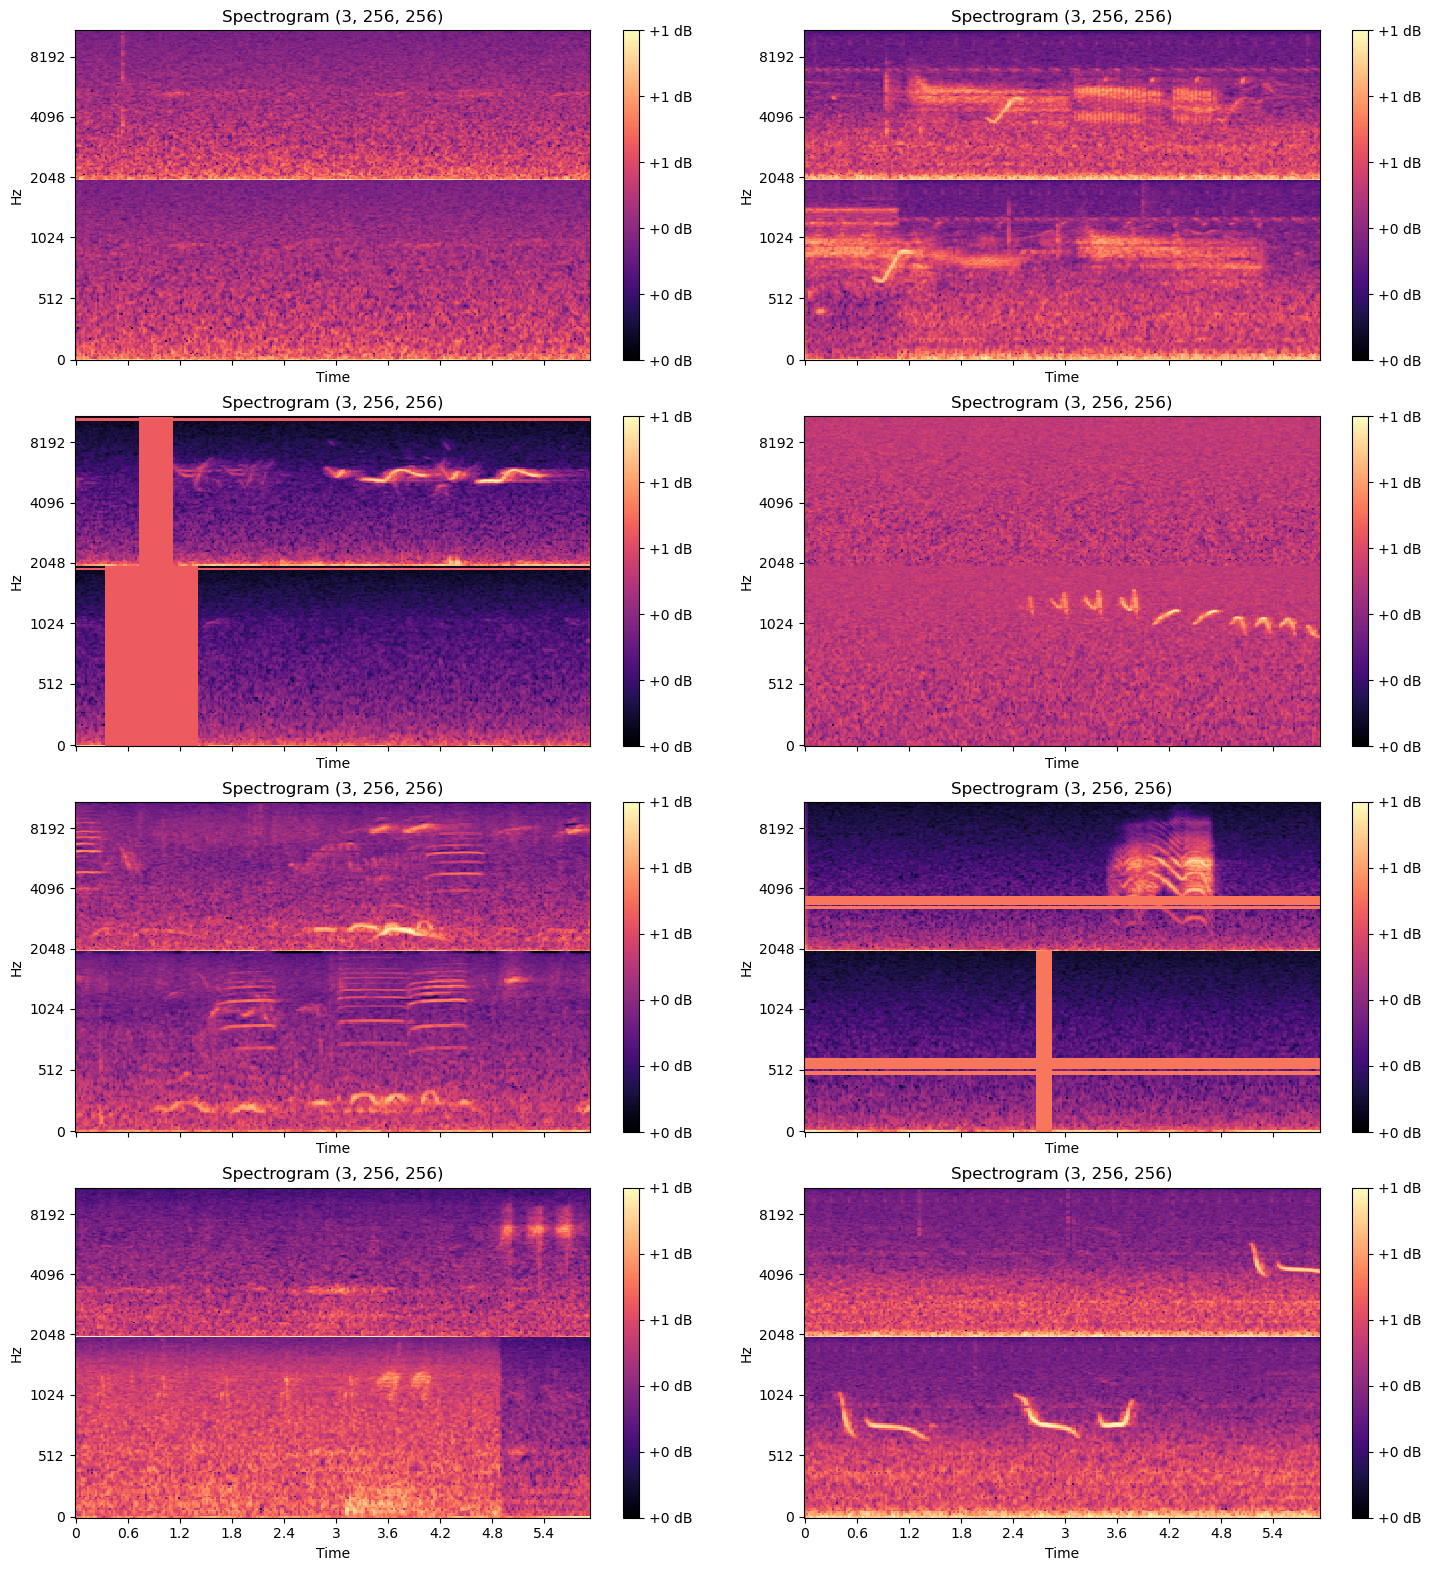

In [40]:
dl_train, dl_val, ds_train, ds_val = get_fold_dataloaders(train_df, val_df)
show_batch(ds_train, 4, 2)

In [41]:
def get_optimizer(lr, params):
    model_optimizer = torch.optim.Adam(
            filter(lambda p: p.requires_grad, params), 
            lr=lr,
            weight_decay=Config.WEIGHT_DECAY )
    interval = "epoch"
    
    lr_scheduler = CosineAnnealingWarmRestarts(
                            model_optimizer, 
                            T_0=Config.EPOCHS, 
                            T_mult=1, 
                            eta_min=1e-6, 
                            last_epoch=-1)
    
    return { "optimizer": model_optimizer, 
             "lr_scheduler": {"scheduler": lr_scheduler,
                        "interval": interval,
                        "monitor": "val_loss",
                        "frequency": 1}}

In [42]:
def padded_cmap(solution, submission, padding_factor=5):
    solution = solution.fillna(0).replace([pd.np.inf, -pd.np.inf], 0)
    submission = submission.fillna(0).replace([pd.np.inf, -pd.np.inf], 0)
    new_rows = []
    for i in range(padding_factor):
        new_rows.append([1 for i in range(len(solution.columns))])
    new_rows = pd.DataFrame(new_rows)
    new_rows.columns = solution.columns
    padded_solution = pd.concat([solution, new_rows]).reset_index(drop=True).copy()
    padded_submission = pd.concat([submission, new_rows]).reset_index(drop=True).copy()
    score = skm.average_precision_score(
        padded_solution.values,
        padded_submission.values,
        average='macro')    
    return score


def padded_cmap_by_class(solution, submission, padding_factor=5):
    solution = solution.fillna(0).replace([np.inf, -np.inf], 0)
    submission = submission.fillna(0).replace([np.inf, -np.inf], 0)
    new_rows = []
    for i in range(padding_factor):
        new_rows.append([1 for i in range(len(solution.columns))])
    new_rows = pd.DataFrame(new_rows)
    new_rows.columns = solution.columns
    padded_solution = pd.concat([solution, new_rows]).reset_index(drop=True).copy()
    padded_submission = pd.concat([submission, new_rows]).reset_index(drop=True).copy()
    
    column_headers = list(solution.columns)
    scores = {}
    
    for column in column_headers:
        score = skm.average_precision_score(
            padded_solution[[column]].values,
            padded_submission[[column]].values,
            average='macro')    
        scores[column] = score
    return scores


def map_score(solution, submission):
    solution = solution.fillna(0).replace([pd.np.inf, -pd.np.inf], 0)
    submission = submission.fillna(0).replace([pd.np.inf, -pd.np.inf], 0)
    score = skm.average_precision_score(
        solution.values,
        submission.values,
        average='micro')  
    return score


def mixup_data(x, y, alpha=Config.MIXUP_ALPHA, device=Config.DEVICE):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [43]:
# Testing Validation Strategy
dummy = val_df[birds].copy()
dummy[birds] = np.random.rand(dummy.shape[0],dummy.shape[1])
pad_5 = padded_cmap(val_df[birds], dummy[birds], padding_factor = 5)
pad_1 = padded_cmap(val_df[birds], dummy[birds], padding_factor = 1)

print(f'Padded cMAP, with padding=5: {pad_5}\n'
     f'Padded cMAP, with padding=1: {pad_1}\n'
     f'MAP score: {map_score(val_df[birds], dummy[birds])}')

Padded cMAP, with padding=5: 0.3465300450659458
Padded cMAP, with padding=1: 0.13633473179214967
MAP score: 0.003827813589384871


In [44]:
class ClassifierHead(nn.Module):
    def __init__(self, num_features, num_classes, dropout_rate=0.35):
        super().__init__()
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.output_layer = nn.Linear(num_features, num_classes)
        
    def forward(self, x):
        x = self.relu(x)  # This was missing the x= !   Try again with that fixed
        x = self.dropout(x)
        x = self.output_layer(x)
        return x

In [ ]:
# Create a loss function that implements label smoothing.
class LabelSmoothingLoss(pl.LightningModule):
    def __init__(self, classes, smoothing=0.1):
        super(LabelSmoothingLoss, self).__init__()
        self.classes = classes
        self.smoothing = smoothing

    def forward(self, pred, target):
        # Get the one-hot representation of the target.
        one_hot_target = torch.nn.functional.one_hot(target, self.classes)

        # Smooth the one-hot target.
        smoothed_target = (1 - self.smoothing) * one_hot_target + self.smoothing / self.classes

        # Compute the cross entropy loss.
        loss = torch.nn.functional.cross_entropy(pred, smoothed_target)

        return loss


In [45]:
class BirdClefModel(pl.LightningModule):
    def __init__(self, 
                 model_name=Config.MODEL, 
                 num_classes = Config.NUM_CLASSES,
                 pretrained = Config.PRETRAINED, 
                 bird_trained = Config.BIRD_TRAINED,
                 replace_head = Config.REPLACE_HEAD,
                 #loss=Config.LOSS_FUNCTION,
                 loss=LabelSmoothingLoss(classes=Config.NUM_CLASSES, Config.LABEL_SMOOTHING)
                 unfreeze=Config.EPOCHS_TO_UNFREEZE_HEAD,
                 unfreeze_backbone=Config.EPOCHS_TO_UNFREEZE_BACKBONE,
                 checkpoint_path=None):
        super().__init__()
        
        self.num_classes = num_classes
        self.backbone = timm.create_model(model_name, pretrained=pretrained)
        self.in_features = self.backbone.classifier.in_features
        self.backbone.classifier = nn.Sequential(nn.Linear(self.in_features, self.in_features))  # 769 from pre-training incl. no-call


        if bird_trained:
            checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
            self.backbone.load_state_dict(checkpoint['state_dict'], strict=False)
        if replace_head:
            self.backbone.classifier = nn.Sequential(nn.Linear(self.in_features, self.num_classes)) 
            for param in self.backbone.classifier.parameters():
                param.requires_grad = True
        else:
            for param in self.backbone.parameters():
                param.requires_grad = False
            self.new_head = ClassifierHead(self.in_features, self.num_classes)    
            self.backbone.classifier = nn.Sequential(self.backbone.classifier, self.new_head)  #only new parts unfrozen initially  seems like a good idea, but doesn't work

        self.loss_function = loss
        self.val_outputs = []
        self.train_outputs = []
        self.metrics_list = []
        self.val_epoch = 0
        self.epoch_to_unfreeze_head = unfreeze
        self.epoch_to_unfreeze_backbone = unfreeze_backbone

        #self.current_epoch = 0
            
    def forward(self,images):
        logits = self.backbone(images)
        return logits
        
    def configure_optimizers(self):
        if Config.WARMUP_EPOCHS and Config.WARMUP_EPOCHS > self.trainer.current_epoch:
            current_lr = Config.START_LR + (Config.LR - Config.START_LR) * (self.trainer.current_epoch / Config.WARMUP_EPOCHS)
        else:
            current_lr = Config.LR
        return get_optimizer(lr=current_lr, params=self.parameters())
    

    def train_with_mixup(self, X, y):
        X, y_a, y_b, lam = mixup_data(X, y, alpha=Config.MIXUP_ALPHA)
        y_pred = self(X)
        loss_mixup = mixup_criterion(self.loss_function, y_pred, y_a, y_b, lam)
        return loss_mixup, y_pred

    def training_step(self, batch, batch_idx):
        image, target = batch        
        if Config.USE_MIXUP:
            loss, y_pred = self.train_with_mixup(image, target)
        else:
            y_pred = self(image)
            loss = self.loss_function(y_pred,target)

        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        train_output = {"train_loss": loss, "logits": y_pred, "targets": target}
        self.train_outputs.append(train_output) 
        return loss        

    def validation_step(self, batch, batch_idx):
        image, target = batch     
        y_pred = self(image)
        val_loss = self.loss_function(y_pred, target)
        self.log("val_loss", val_loss, on_step=True, on_epoch=True, logger=True, prog_bar=True)
        output = {"val_loss": val_loss, "logits": y_pred, "targets": target}  #new line
        self.val_outputs.append(output)  #new line
        return {"val_loss": val_loss, "logits": y_pred, "targets": target}
    
    def train_dataloader(self):
        return self._train_dataloader 
    
    def validation_dataloader(self):
        return self._validation_dataloader
       
    def on_validation_epoch_end(self):  #breaks with these two lines in
        val_outputs = self.val_outputs
        avg_val_loss = torch.stack([x['val_loss'] for x in val_outputs]).mean().cpu().detach().numpy()
        output_val_logits = torch.cat([x['logits'] for x in val_outputs],dim=0)
        val_targets = torch.cat([x['targets'] for x in val_outputs],dim=0).cpu().detach().numpy() 
        
        train_outputs = self.train_outputs
        if train_outputs:
            train_losses = [x['train_loss'].cpu().detach().numpy() for x in train_outputs]
            avg_train_loss = sum(train_losses) / len(train_losses) if train_losses else 0.0
            output_train_logits = torch.cat([x['logits'] for x in train_outputs],dim=0)
            train_targets = torch.cat([x['targets'] for x in train_outputs],dim=0).cpu().detach().numpy()
        else: 
            avg_train_loss = avg_val_loss #we need this because the first time it's an empty list
            output_train_logits = torch.ones(1,output_val_logits.shape[1])
            train_targets = torch.zeros(1, output_val_logits.shape[1])
            
    
        
        if Config.LOSS_FUNCTION == nn.CrossEntropyLoss():
            val_probs = F.softmax(output_val_logits, dim=1).cpu().detach().numpy()
            train_probs = F.softmax(output_train_logits, dim=1).cpu().detach().numpy()
        else:
            val_probs = output_val_logits.sigmoid().cpu().detach().numpy()
            train_probs = output_train_logits.sigmoid().cpu().detach().numpy()
  
        val_pred_df = pd.DataFrame(val_probs, columns = birds)
        val_target_df = pd.DataFrame(val_targets, columns = birds)
        train_pred_df = pd.DataFrame(train_probs, columns = birds)
        train_target_df = pd.DataFrame(train_targets, columns = birds)
       
        avg_score = padded_cmap(val_target_df, val_pred_df, padding_factor = 5)
        avg_score2 = padded_cmap(val_target_df, val_pred_df, padding_factor = 3)
        avg_score3 = skm.label_ranking_average_precision_score(val_targets,val_probs)        
        
        if self.val_epoch > 0:
            avg_score4 = padded_cmap(train_target_df, train_pred_df, padding_factor = 5)
            self.metrics_list.append({'train_loss':avg_train_loss, 'val_loss': avg_val_loss, 'val_prec':avg_score3, 'train_prec':avg_score4, })
        
        # competition_metrics(output_val,target_val)
        print(f'epoch {self.current_epoch} train loss {avg_train_loss}')
        print(f'epoch {self.current_epoch} validation loss {avg_val_loss}')
        print(f'epoch {self.current_epoch} validation C-MAP score pad 5 {avg_score}')
        print(f'epoch {self.current_epoch} validation C-MAP score pad 3 {avg_score2}')
        print(f'epoch {self.current_epoch} validation AP score {avg_score3 or None}')
        
        val_target_df.to_pickle(Path(Config.OUT_DIR) / f'Exp{Config.EXPERIMENT}/val_target_df.pkl')
        val_pred_df.to_pickle(Path(Config.OUT_DIR) / f'Exp{Config.EXPERIMENT}/val_pred_df.pkl') 
        train_target_df.to_pickle(Path(Config.OUT_DIR) / f'Exp{Config.EXPERIMENT}/train_target_df.pkl')
        train_pred_df.to_pickle(Path(Config.OUT_DIR) / f'Exp{Config.EXPERIMENT}/train_pred_df.pkl')  
        
        self.val_outputs = []
        self.train_outputs = []
        self.val_epoch +=1
    
        return
    
    def on_train_epoch_end(self, *args, **kwargs):
        if self.current_epoch == self.epoch_to_unfreeze_head:
        # Unfreeze the old classifier head
            for param in self.backbone.classifier.parameters():
                param.requires_grad = True
            #Consider creating a new optimiser at this point, like this:
            #self.optimizer = torch.optim.Adam([
                #{'params': self.backbone.parameters(), 'lr': 1e-5},
                #{'params': self.new_head.parameters(), 'lr': 1e-4}])
        
        if self.current_epoch == self.epoch_to_unfreeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = True
            print(f'Unfreezing the backbone after {self.current_epoch} epochs')
    
    def get_my_metrics_list(self):
        return self.metrics_list

In [46]:
# Load the checkpoint
if Config.BIRD_TRAINED:
    checkpoint = torch.load(Config.MODEL_CKPT)
    # Print the architecture of the checkpoint
    print(checkpoint.keys())

In [47]:
def run_training():
    print(f"Running training...")
    logger = None
    dl_train, dl_val, _, _ = get_fold_dataloaders(train_df, val_df)
    audio_model = BirdClefModel(checkpoint_path=Config.MODEL_CKPT)

    early_stop_callback = EarlyStopping(monitor="val_loss", 
                                        min_delta=Config.MIN_DELTA, 
                                        patience=Config.PATIENCE, 
                                        verbose= True, 
                                        mode="min")
    
    # saves top- checkpoints based on "val_loss" metric
    checkpoint_callback = ModelCheckpoint(save_top_k=Config.KEEP_LAST,
                                          monitor="val_loss",
                                          mode="min",
                                          dirpath=save_path,
                                          save_last= True,
                                          save_weights_only=True, 
                                          verbose= True,
                                          #filename=f'birdCLEF23-{epoch:02d}-{val_loss:.4f}',  need to figure this out so It can update to a dataset
)
    
    callbacks_to_use = [checkpoint_callback, early_stop_callback] #MonitoringCallback   # work more on this later.
    
    
    trainer = pl.Trainer(
        gpus=1,
        val_check_interval=0.5,
        deterministic=True,
        max_epochs=Config.EPOCHS,
        logger=logger,
        auto_lr_find=Config.AUTOLRFIND,    
        callbacks=callbacks_to_use,
        precision=Config.PRECISION, accelerator='gpu')

    
    print("Running trainer.fit")
    trainer.fit(audio_model, train_dataloaders = dl_train, val_dataloaders = dl_val)       
    gc.collect()
    torch.cuda.empty_cache()
    
    return audio_model.get_my_metrics_list()

In [48]:
metrics = run_training()


Running training...


Using 16bit None Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | backbone      | EfficientNet     | 20.5 M
1 | loss_function | CrossEntropyLoss | 0     
---------------------------------------------------
20.5 M    Trainable params
0         Non-trainable params
20.5 M    Total params
41.034    Total estimated model params size (MB)


Running trainer.fit


Sanity Checking: 0it [00:00, ?it/s]

epoch 0 train loss 5.56744384765625
epoch 0 validation loss 5.56744384765625
epoch 0 validation C-MAP score pad 5 0.9914336792469781
epoch 0 validation C-MAP score pad 3 0.9890792448784975
epoch 0 validation AP score 0.04134329010913057


Training: 0it [00:00, ?it/s]

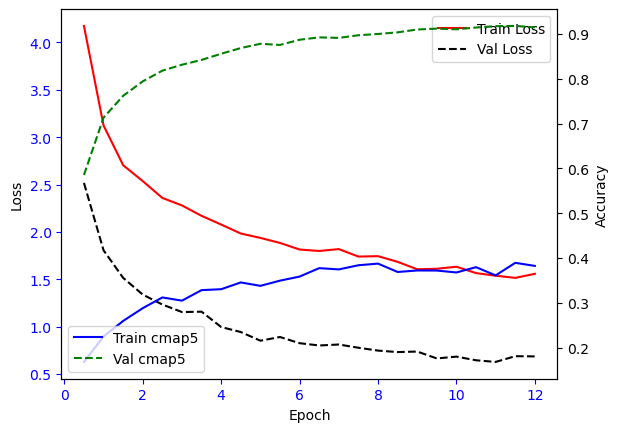

In [ ]:
train_losses = [x['train_loss'] for x in metrics]
val_losses = [x['val_loss'] for x in metrics]  
train_precision = [x['train_prec'] for x in metrics]  
val_precision = [x['val_prec'] for x in metrics] 
time_axis = [0.5*x for x in range(1,len(val_losses)+1)]

fig, ax = plt.subplots()
plt.plot(time_axis, train_losses, 'r', label='Train Loss')
plt.plot(time_axis, val_losses, '--k', label='Val Loss')
plt.legend()
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
ax.tick_params('both', colors='r')

# Get second axis
ax2 = ax.twinx()
plt.plot(time_axis, train_precision, 'b', label='Train cmap5')
plt.plot(time_axis, val_precision, '--g', label='Val cmap5')
ax2.set_ylabel('Accuracy')
plt.legend()
plt.legend(loc='lower left')
ax.tick_params('both', colors='b')
plt.savefig(Path(Config.OUT_DIR) / f'Exp{Config.EXPERIMENT}/monitor.jpg')

In [ ]:
def plot_by_class(df_target, df_pred):
    cmap5_by_class = padded_cmap_by_class(df_target, df_pred, padding_factor=5)
    col_sums = [(col, df_target[col].sum()) for col in df_target.columns]
    names_by_frequency = sorted(col_sums, key=lambda x: x[1], reverse=True)
    # extract names and counts as separate lists
    names = [name for name, _ in names_by_frequency]
    counts = [count for _, count in names_by_frequency]
    scores = [cmap5_by_class[name] for name in names]
    df = pd.DataFrame({'names': names, 'counts': counts, 'scores': scores})
    df["scores"] = pd.to_numeric(df["scores"])
    df["counts"] = pd.to_numeric(df["counts"])
    fig = px.bar(df, x='scores', y='names', color='counts', orientation='h', hover_data=['counts', 'scores'], range_x=[0, 1])
    fig.update_layout(height=1200)
    fig.show()
    return names, scores,  counts

In [ ]:
if in_kaggle:
    pred = pd.read_pickle(Path(Config.OUT_DIR) / f'Exp{Config.EXPERIMENT}/val_pred_df.pkl')
    true = pd.read_pickle(Path(Config.OUT_DIR) / f'Exp{Config.EXPERIMENT}/val_target_df.pkl')
else:
    pred = pd.read_pickle(Path(Config.OUT_DIR) / f'Exp{Config.EXPERIMENT}/val_pred_df.pkl')
    true = pd.read_pickle(Path(Config.OUT_DIR) / f'Exp{Config.EXPERIMENT}/val_target_df.pkl')

pred.head()

abethr1   abhori1   abythr1   afbfly1   afdfly1   afecuc1   affeag1  \
0  0.359131  0.004040  0.000432  0.000052  0.000052  0.003721  0.000315   
1  0.353027  0.001668  0.004005  0.000315  0.024521  0.002342  0.000083   
2  0.713379  0.000448  0.002590  0.000997  0.000106  0.037201  0.000134   
3  0.000042  0.000562  0.000059  0.000301  0.000034  0.000730  0.000009   
4  0.001037  0.990234  0.004906  0.001536  0.007519  0.009056  0.005119   

    afgfly1   afghor1   afmdov1  ...       yesbar1   yespet1   yetgre1  \
0  0.000043  0.000113  0.001240  ...  1.031160e-05  0.001235  0.006985   
1  0.001081  0.000486  0.001668  ...  2.032518e-05  0.000785  0.001169   
2  0.000069  0.002855  0.000553  ...  2.861023e-06  0.000436  0.005138   
3  0.000002  0.000084  0.000152  ...  1.192093e-07  0.000001  0.000710   
4  0.001367  0.013481  0.002306  ...  1.720428e-03  0.008064  0.002855   

    yewgre1   no-call   afpkin1   golher1   lotlap1   whctur2   whhsaw1  
0  0.000174  0.000333  0.004005  0.000102  0.000389  0.000274  0.002388  
1  0.007065  0.001124  0.001235  0.000144  0.000755  0.000017  0.000682  
2  0.000058  0.000170  0.000333  0.000116  0.000167  0.000012  0.000582  
3  0.000011  0.000008  0.001707  0.000497  0.000006  0.000035  0.013535  
4  0.004299  0.000993  0.031021  0.002453  0.005936  0.004150  0.025085  

[5 rows x 265 columns]

In [ ]:
true.head()

abethr1  abhori1  abythr1  afbfly1  afdfly1  afecuc1  affeag1  afgfly1  \
0      1.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
1      1.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
2      1.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
3      1.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
4      0.0      1.0      0.0      0.0      0.0      0.0      0.0      0.0   

   afghor1  afmdov1  ...  yesbar1  yespet1  yetgre1  yewgre1  no-call  \
0      0.0      0.0  ...      0.0      0.0      0.0      0.0      0.0   
1      0.0      0.0  ...      0.0      0.0      0.0      0.0      0.0   
2      0.0      0.0  ...      0.0      0.0      0.0      0.0      0.0   
3      0.0      0.0  ...      0.0      0.0      0.0      0.0      0.0   
4      0.0      0.0  ...      0.0      0.0      0.0      0.0      0.0   

   afpkin1  golher1  lotlap1  whctur2  whhsaw1  
0      0.0      0.0      0.0      0.0      0.0  
1      0.0      0.0      0.0      0.0      0.0  
2      0.0      0.0      0.0      0.0      0.0  
3      0.0      0.0      0.0      0.0      0.0  
4      0.0      0.0      0.0      0.0      0.0  

[5 rows x 265 columns]

In [ ]:
padded_cmap(true, pred, padding_factor = 5)

0.9020568299781665

In [ ]:
val_names, val_scores, val_counts = plot_by_class(true, pred)
#plt.savefig(Path(Config.OUT_DIR) / f'Exp{Config.EXPERIMENT}/val_precision.jpg')

In [ ]:
no_call_idx = val_names.index('no-call')
f'There were {val_counts[no_call_idx]} no-calls in the val batch, with a mean cmap5 score of {val_scores[no_call_idx]}'

'There were 3.0 no-calls in the val batch, with a mean cmap5 score of 0.8150440163862983'

In [ ]:
padded_cmap(true, pred, padding_factor = 5)      

0.9020568299781665

In [ ]:
if in_kaggle:
    train_pred = pd.read_pickle(Path(Config.OUT_DIR) / f'Exp{Config.EXPERIMENT}/train_pred_df.pkl')
    train_true = pd.read_pickle(Path(Config.OUT_DIR) / f'Exp{Config.EXPERIMENT}/train_target_df.pkl')
else:
    train_pred = pd.read_pickle(Path(Config.OUT_DIR) / f'Exp{Config.EXPERIMENT}/train_pred_df.pkl')
    train_true = pd.read_pickle(Path(Config.OUT_DIR) / f'Exp{Config.EXPERIMENT}/train_target_df.pkl')

In [ ]:
train_names, train_scores, train_counts = plot_by_class(train_true, train_pred)
#plt.savefig(Path(Config.OUT_DIR) / f'Exp{Config.EXPERIMENT}/val_precision.jpg')

In [ ]:
no_call_idx = train_names.index('no-call')
f'There were {train_counts[no_call_idx]} no-calls in the train batch, with a mean cmap5 score of {train_scores[no_call_idx]}'

'There were 16.0 no-calls in the train batch, with a mean cmap5 score of 0.4999888497409157'